## 1. 数据预处理

处理流程：[提取原始PDF数据] → [pandas 处理] → [保存 CSV]

In [1]:
# 控制调试输出的开关
DEBUG = not False

### 1.1 配置参数 
> 需根据实际文件路径修改
- 需要解析 PDF 文件路径
- 输出文件 CSV 路径
- 输出文件 CSV 表头

In [2]:
CONST_PDF_PATH = "./assets/2024年四川省重点项目名单.pdf"  
CONST_OUTPUT_DIR = "./outputs"
CONST_ORIGIN_HEADERS = ["总序号", "分序号", "项目名称", "建设地址"]
CONST_TARGET_HEADERS = ["项目名称", "建设地址", "一级项目领域", "二级项目领域", "三级项目领域", "建设性质"]


### 1.2 使用 pdfplumber 解析 PDF 页面数据

In [3]:
# 调试 pdfplumber
import pdfplumber

if DEBUG and False:
    with pdfplumber.open(CONST_PDF_PATH) as pdf:
        page = pdf.pages[0]
        img = page.crop(bbox=[0, 0, 584, 142]).to_image() 
        img.show()  # 显示图像，手动观察并估算坐标

In [4]:
import pdfplumber
import re

# 申明一个(上下文)变量，一级项目领域，类型为字符串
Level_1_Project_Domain = ""
Level_2_Project_Domain = ""
Level_3_Project_Domain = ""

def extract_table_from_pdf(pdf_path):
    result_key_project_list = []  # 存储所有页面的表格数据

    with pdfplumber.open(pdf_path) as pdf:
        # 获取实际总页数
        total_pages = len(pdf.pages)  
        
        # 遍历PDF的每一页
        for page_num in range(0, total_pages):
        # for page_num in range(0, 10):
            page = pdf.pages[page_num]
            print(f"\r正在解析第 {page_num + 1} 页...", end='', flush=True)
            
            # 提取当前页所有表格
            table = page.extract_table(
                # 参考：
                # https://github.com/jsvine/pdfplumber?tab=readme-ov-file#table-extraction-settings
                table_settings={
                    "vertical_strategy": "lines",  # 按竖线识别列边界
                    "horizontal_strategy": "lines",  # 按横线识别行边界
                    "text_y_tolerance": 10,  # 文本垂直方向容错
                    "text_x_tolerance": 5,   # 文本水平方向容错
                }
            )

            # 提取页面标题，解析(项目类型)
            title_text = page.crop(bbox=[0, 0, 584, 130]).extract_text() or ""

            construction_nature = ""

            if title_text.find("新建") != -1 or title_text.find("新开工") != -1 :
                construction_nature = "新建"

            if title_text.find("续建") != -1:
                construction_nature = "续建"
            
            # 使用新函数处理表格数据
            table_data = process_table_rows(table, construction_nature)

            if False:
                print(f"🌟第 {page_num + 1} 页处理后的数据：")
                for row in table_data:
                    print(row)

            # 将处理后的数据添加到总数据列表中
            result_key_project_list.extend(table_data)

        print(f"\r解析完成！总共 {total_pages} 页。")
    
    return result_key_project_list

def process_table_rows(table, construction_nature):
    # 存储当前表格处理后的数据
    # example:
    # [
    #     ["项目名称", "建设地址", "一级项目领域", "二级项目领域", "三级项目领域", "建设性质(新建/续建)"]
    #     [……], 
    # ]
    result_list = []  

    for index, row in enumerate(table):
        # 跳过表头行
        if index < 2:
            continue  

        # 解构为单元格，总序号、分序号、项目名称、建设地址
        # 移除两侧潜在的空格
        total_seq_cell, sub_seq_cell, project_name_cell, construction_address_cell = [cell.strip() if cell else "" for cell in row]

        if False:
            print(f"🪨原始 {index + 1} 行：{row}")

        # 清理项目名称单元格，去除换行符和括号及其后内容
        # "教育、文化、体育及社会服务（16项）" -> "教育、文化、体育及社会服务"
        if not construction_address_cell or construction_address_cell == '':
            project_name_cell = remove_after_first_paren(project_name_cell.replace("\n", ""))

        global Level_1_Project_Domain 
        global Level_2_Project_Domain 
        global Level_3_Project_Domain 

        # total_seq_cell 为 '一二三四五' 其中一个汉字，则使用 project_name_cell 作为 一级项目领域
        if re.match(r'^[一二三四五]$', total_seq_cell):
            Level_1_Project_Domain = project_name_cell
            Level_2_Project_Domain = ""
            Level_3_Project_Domain = ""
            continue

        if re.match(r'^（[一二三四五]）$', total_seq_cell):
            Level_2_Project_Domain = project_name_cell
            Level_3_Project_Domain = ""
            continue

        if total_seq_cell in ['I', 'Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ', 'II', 'III', 'IV', 'V', 'Ⅴ', 'VI']:
            Level_3_Project_Domain = project_name_cell
            continue

        # 跳过建设地址为空的行
        if not construction_address_cell or construction_address_cell == '':
            continue

        # 建设地址的换行符处理为空格
        address_city = construction_address_cell.replace("\n", " ")

        refined_data = [
            project_name_cell, 
            address_city, 
            Level_1_Project_Domain, 
            Level_2_Project_Domain,
            Level_3_Project_Domain,
            construction_nature
        ]

        if False:
            print(f"🌈已经处理第 {index + 1} 行：{refined_data}")

        result_list.append(refined_data)

    return result_list

def remove_after_first_paren(text):
    # 使用正则表达式匹配第一个左括号及其后面的所有内容并替换为空字符串
    return re.sub(r'（.*', '', text)
    
if DEBUG and False:
    result_key_project_list = extract_table_from_pdf(CONST_PDF_PATH) 

    print(f"🌟所有表格处理后的数据：")
    for row in result_key_project_list:
        print(row)

### 1.3 使用 pandas 数据清洗

转换为 DataFrame 并清洗

In [5]:
import pandas as pd

def convert_to_dataframe(data, columns):
    df = pd.DataFrame(data, columns=columns)

    # 将 df 中"二级项目领域"列，"现代服务"转化为"现代服务业"
    df.iloc[:, 3] = df.iloc[:, 3].replace("现代服务", "现代服务业")


    if DEBUG and False:
        print(df.shape)       # 输出 (2, 2) → 表示 2 行 2 列
        print(df.columns)     # 输出 Index(['姓名', '年龄'], dtype='object') → 列名
        print(df.index)       # 输出 RangeIndex(start=0, stop=2, step=1) → 行索引
        print(df.dtypes)      # 输出各列数据类型（如 姓名: object，年龄: int64）
        print(df.values)      # 输出 numpy 数组形式的原始数据 → [['张三' 20] ['李四' 22]]
    return df

if DEBUG and False:
    result = extract_table_from_pdf(CONST_PDF_PATH) 
    df = convert_to_dataframe(result, CONST_TARGET_HEADERS)

### 1.4 保存结果（CSV）

In [6]:
import os

def save_results(df, pdf_path, output_dir):

    # 确保输出目录存在
    os.makedirs(output_dir, exist_ok=True)

    # 生成输出文件路径
    output_csv = get_output_csv_path(pdf_path, output_dir)

    # 保存为 CSV（兼容更多工具，如 Excel、Python读取）
    # utf-8-sig 解决中文乱码
    df.to_csv(output_csv, index=False, encoding="utf-8-sig") 
    return output_csv

def get_output_csv_path(pdf_path, output_dir):
    """
    根据PDF文件名生成输出CSV文件路径
    
    Args:
        pdf_path: PDF文件路径
        output_dir: 输出目录
    
    Returns:
        生成的CSV文件完整路径
    """

    # 获取PDF文件名（不含扩展名）
    pdf_filename = os.path.splitext(os.path.basename(pdf_path))[0]
    # 构造输出CSV文件路径
    output_csv = os.path.join(output_dir, f"{pdf_filename}_解析结果.csv")
    return output_csv

if DEBUG and False:
    result = extract_table_from_pdf(CONST_PDF_PATH) 
    df = convert_to_dataframe(result, CONST_TARGET_HEADERS)
    save_results(df, CONST_PDF_PATH, CONST_OUTPUT_DIR)


### 1.5 数据处理主函数运行 (main)
> 组织各个步骤函数运行

In [7]:
from datetime import datetime

def mainDataPreprocess(pdf_path, out_dir, target_columns):
    # 提取表格数据
    raw_data = extract_table_from_pdf(pdf_path)
    
    # 转换为DataFrame
    df = convert_to_dataframe(raw_data, columns=target_columns)
    
    # 保存结果
    saved_path = save_results(df, pdf_path, out_dir)

    # 获取当前时间
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # 输出结果信息
    print(f"解析完成({current_time})！共提取{len(df)}条项目数据，已保存至：")
    print(f"- CSV: {saved_path}")
    
    # 打印前5条数据验证结果
    print("\n解析结果预览（前5条）：")
    print(df.head())

# 运行主程序
if __name__ == "__main__":
    mainDataPreprocess(
        pdf_path="./assets/2024年四川省重点项目名单.pdf", 
        out_dir=CONST_OUTPUT_DIR,
        target_columns=CONST_TARGET_HEADERS
    )

    mainDataPreprocess(
        pdf_path="./assets/2025年四川省重点项目名单.pdf", 
        out_dir=CONST_OUTPUT_DIR,
        target_columns=CONST_TARGET_HEADERS
    )

解析完成！总共 76 页。
解析完成(2025-11-08 11:32:39)！共提取727条项目数据，已保存至：
- CSV: ./outputs/2024年四川省重点项目名单_解析结果.csv

解析结果预览（前5条）：
                 项目名称     建设地址  一级项目领域  二级项目领域 三级项目领域 建设性质
0               国家实验室  四川 天府新区  基础设施项目  新型基础设施          续建
1  极深地下极低辐射本底前沿物理实验设施  凉山州 冕宁县  基础设施项目  新型基础设施          续建
2       光场调控装置及地方配套项目  四川 天府新区  基础设施项目  新型基础设施          续建
3      多态耦合轨道交通动模试验平台  四川 天府新区  基础设施项目  新型基础设施          续建
4     中国地震科学实验场（在川部分）   有关市（州）  基础设施项目  新型基础设施          续建
解析完成！总共 116 页。
解析完成(2025-11-08 11:32:40)！共提取833条项目数据，已保存至：
- CSV: ./outputs/2025年四川省重点项目名单_解析结果.csv

解析结果预览（前5条）：
                    项目名称     建设地址  一级项目领域  二级项目领域 三级项目领域 建设性质
0          光场调控装置及地方配套项目  四川 天府新区  基础设施项目  新型基础设施          续建
1                 磁浮飞行风洞  四川 天府新区  基础设施项目  新型基础设施          续建
2                准环对称仿星器  四川 天府新区  基础设施项目  新型基础设施          续建
3          红外太赫兹自由电子激光装置  成都市 双流区  基础设施项目  新型基础设施          续建
4  中国地震科学实验场建设工程项目（四川部分）   有关市（州）  基础设施项目  新型基础设施          续建


## 2. 数据分析

### 2.1 关键词维度分析

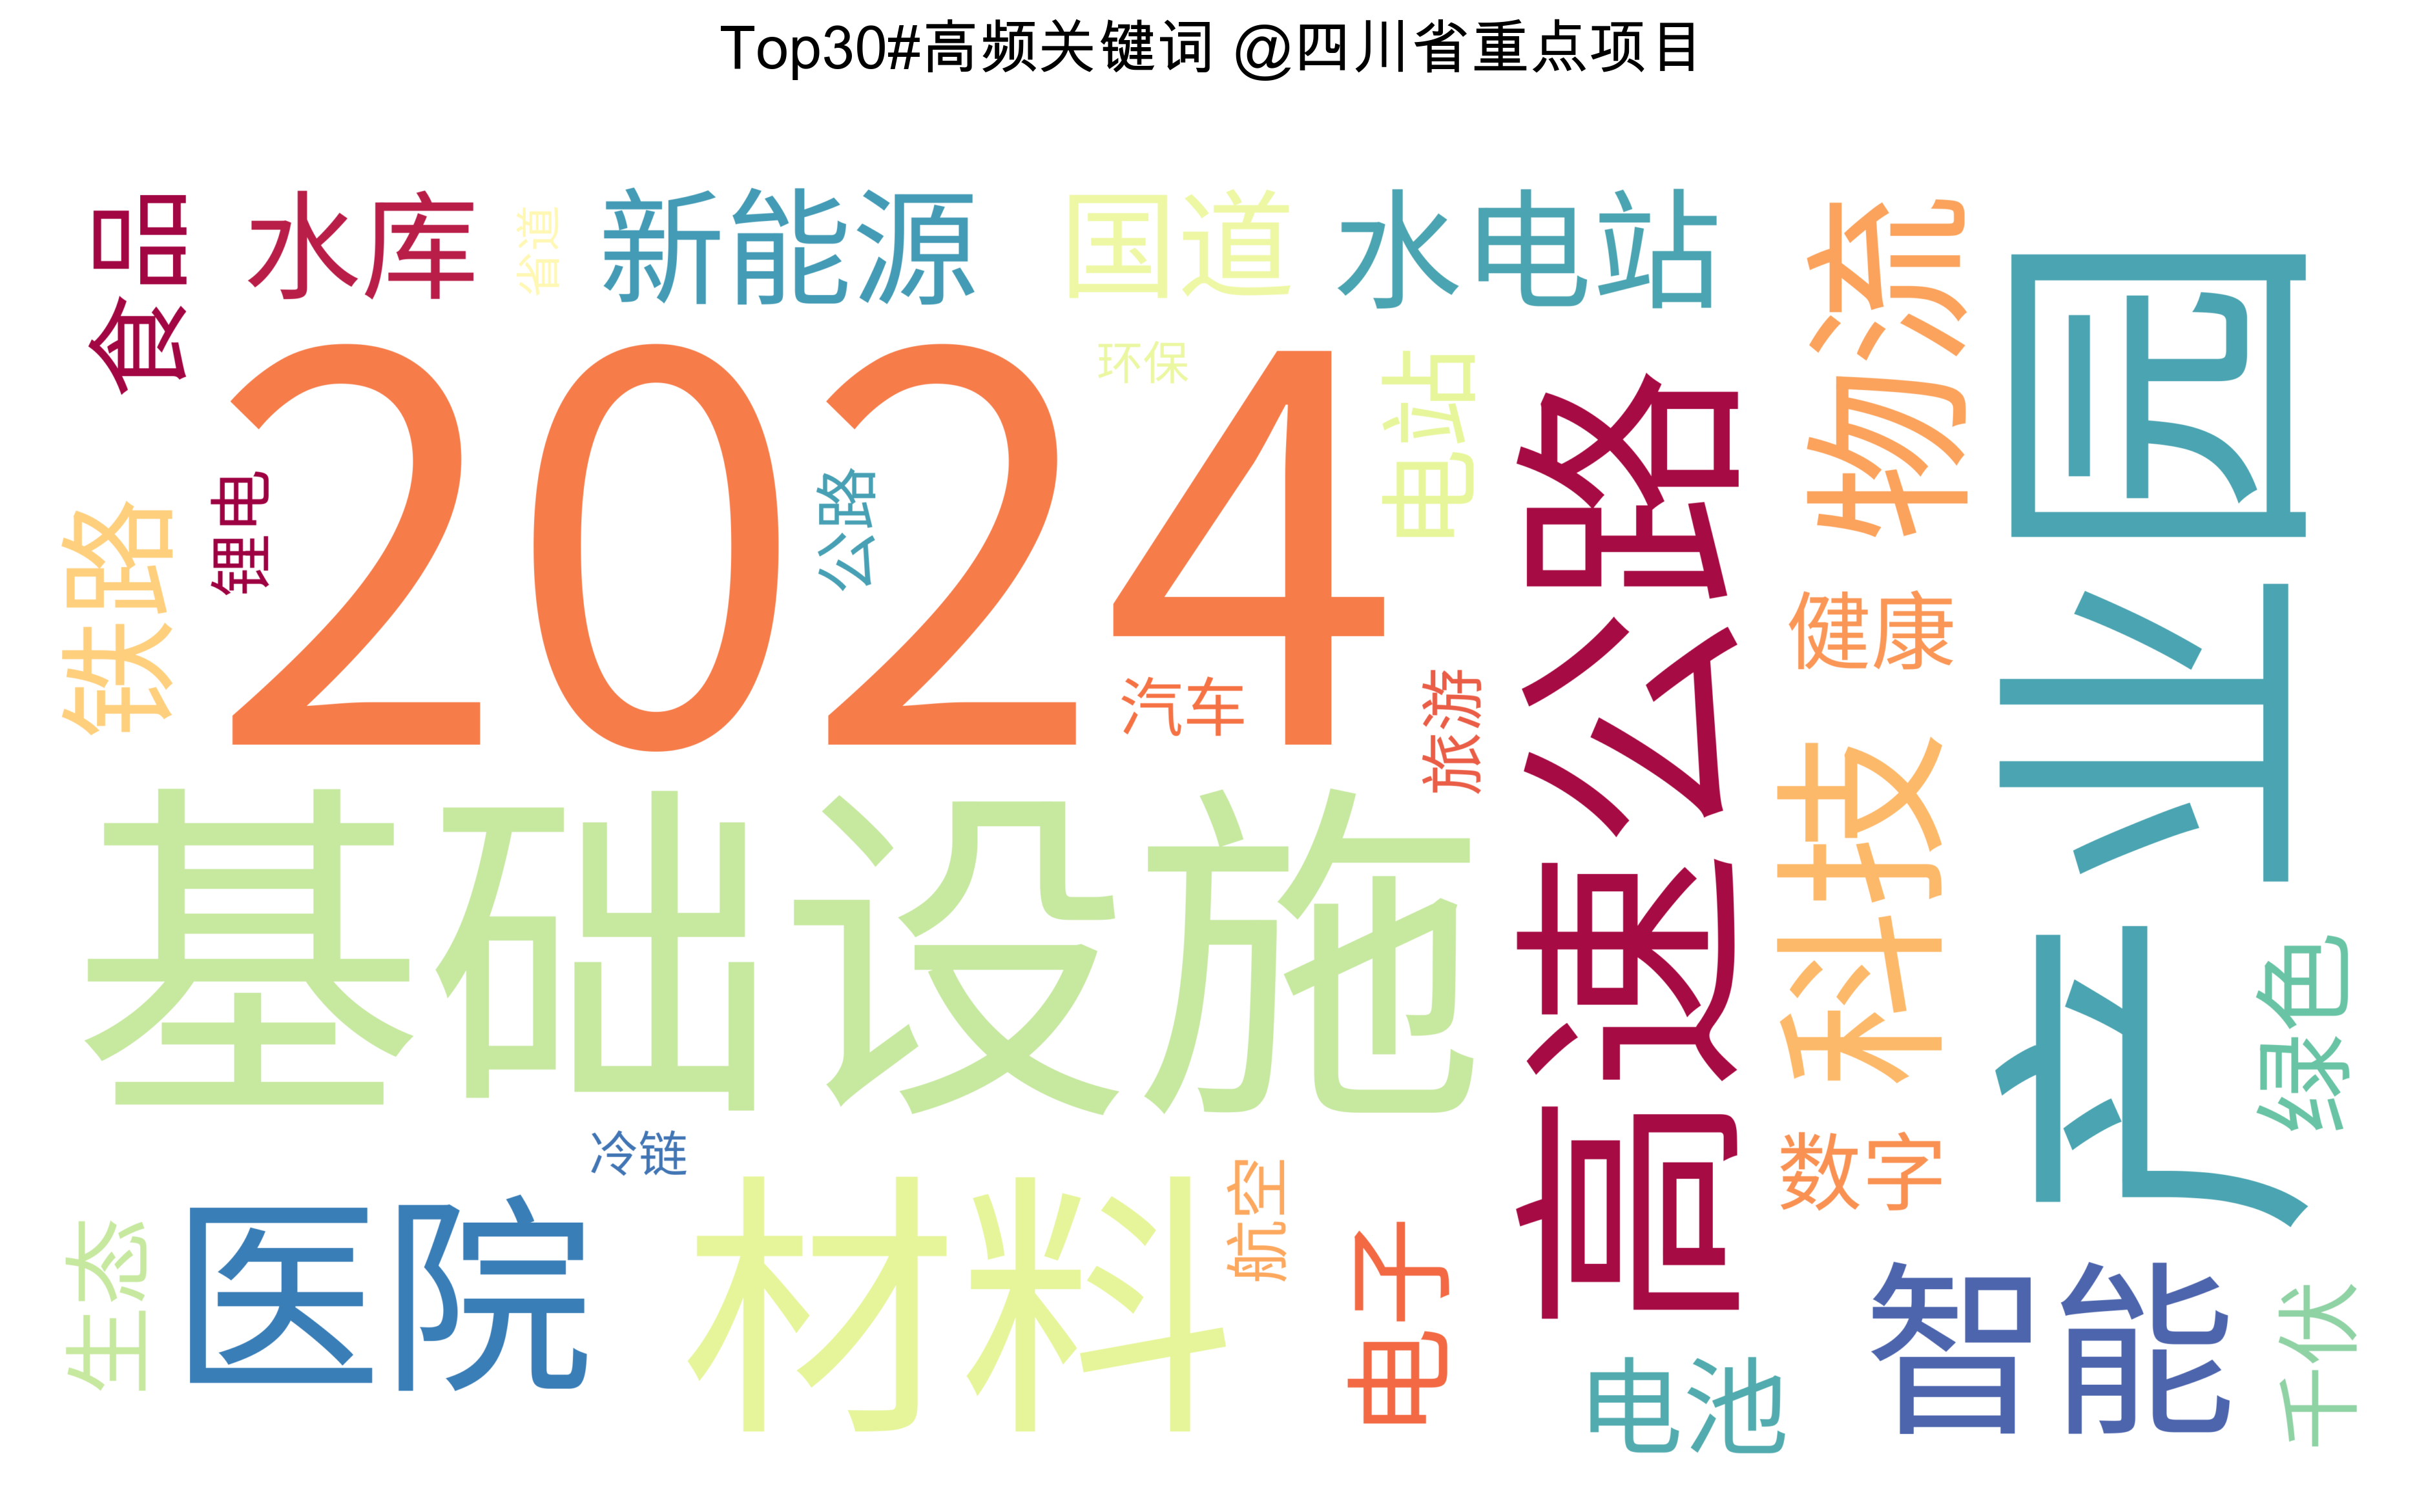

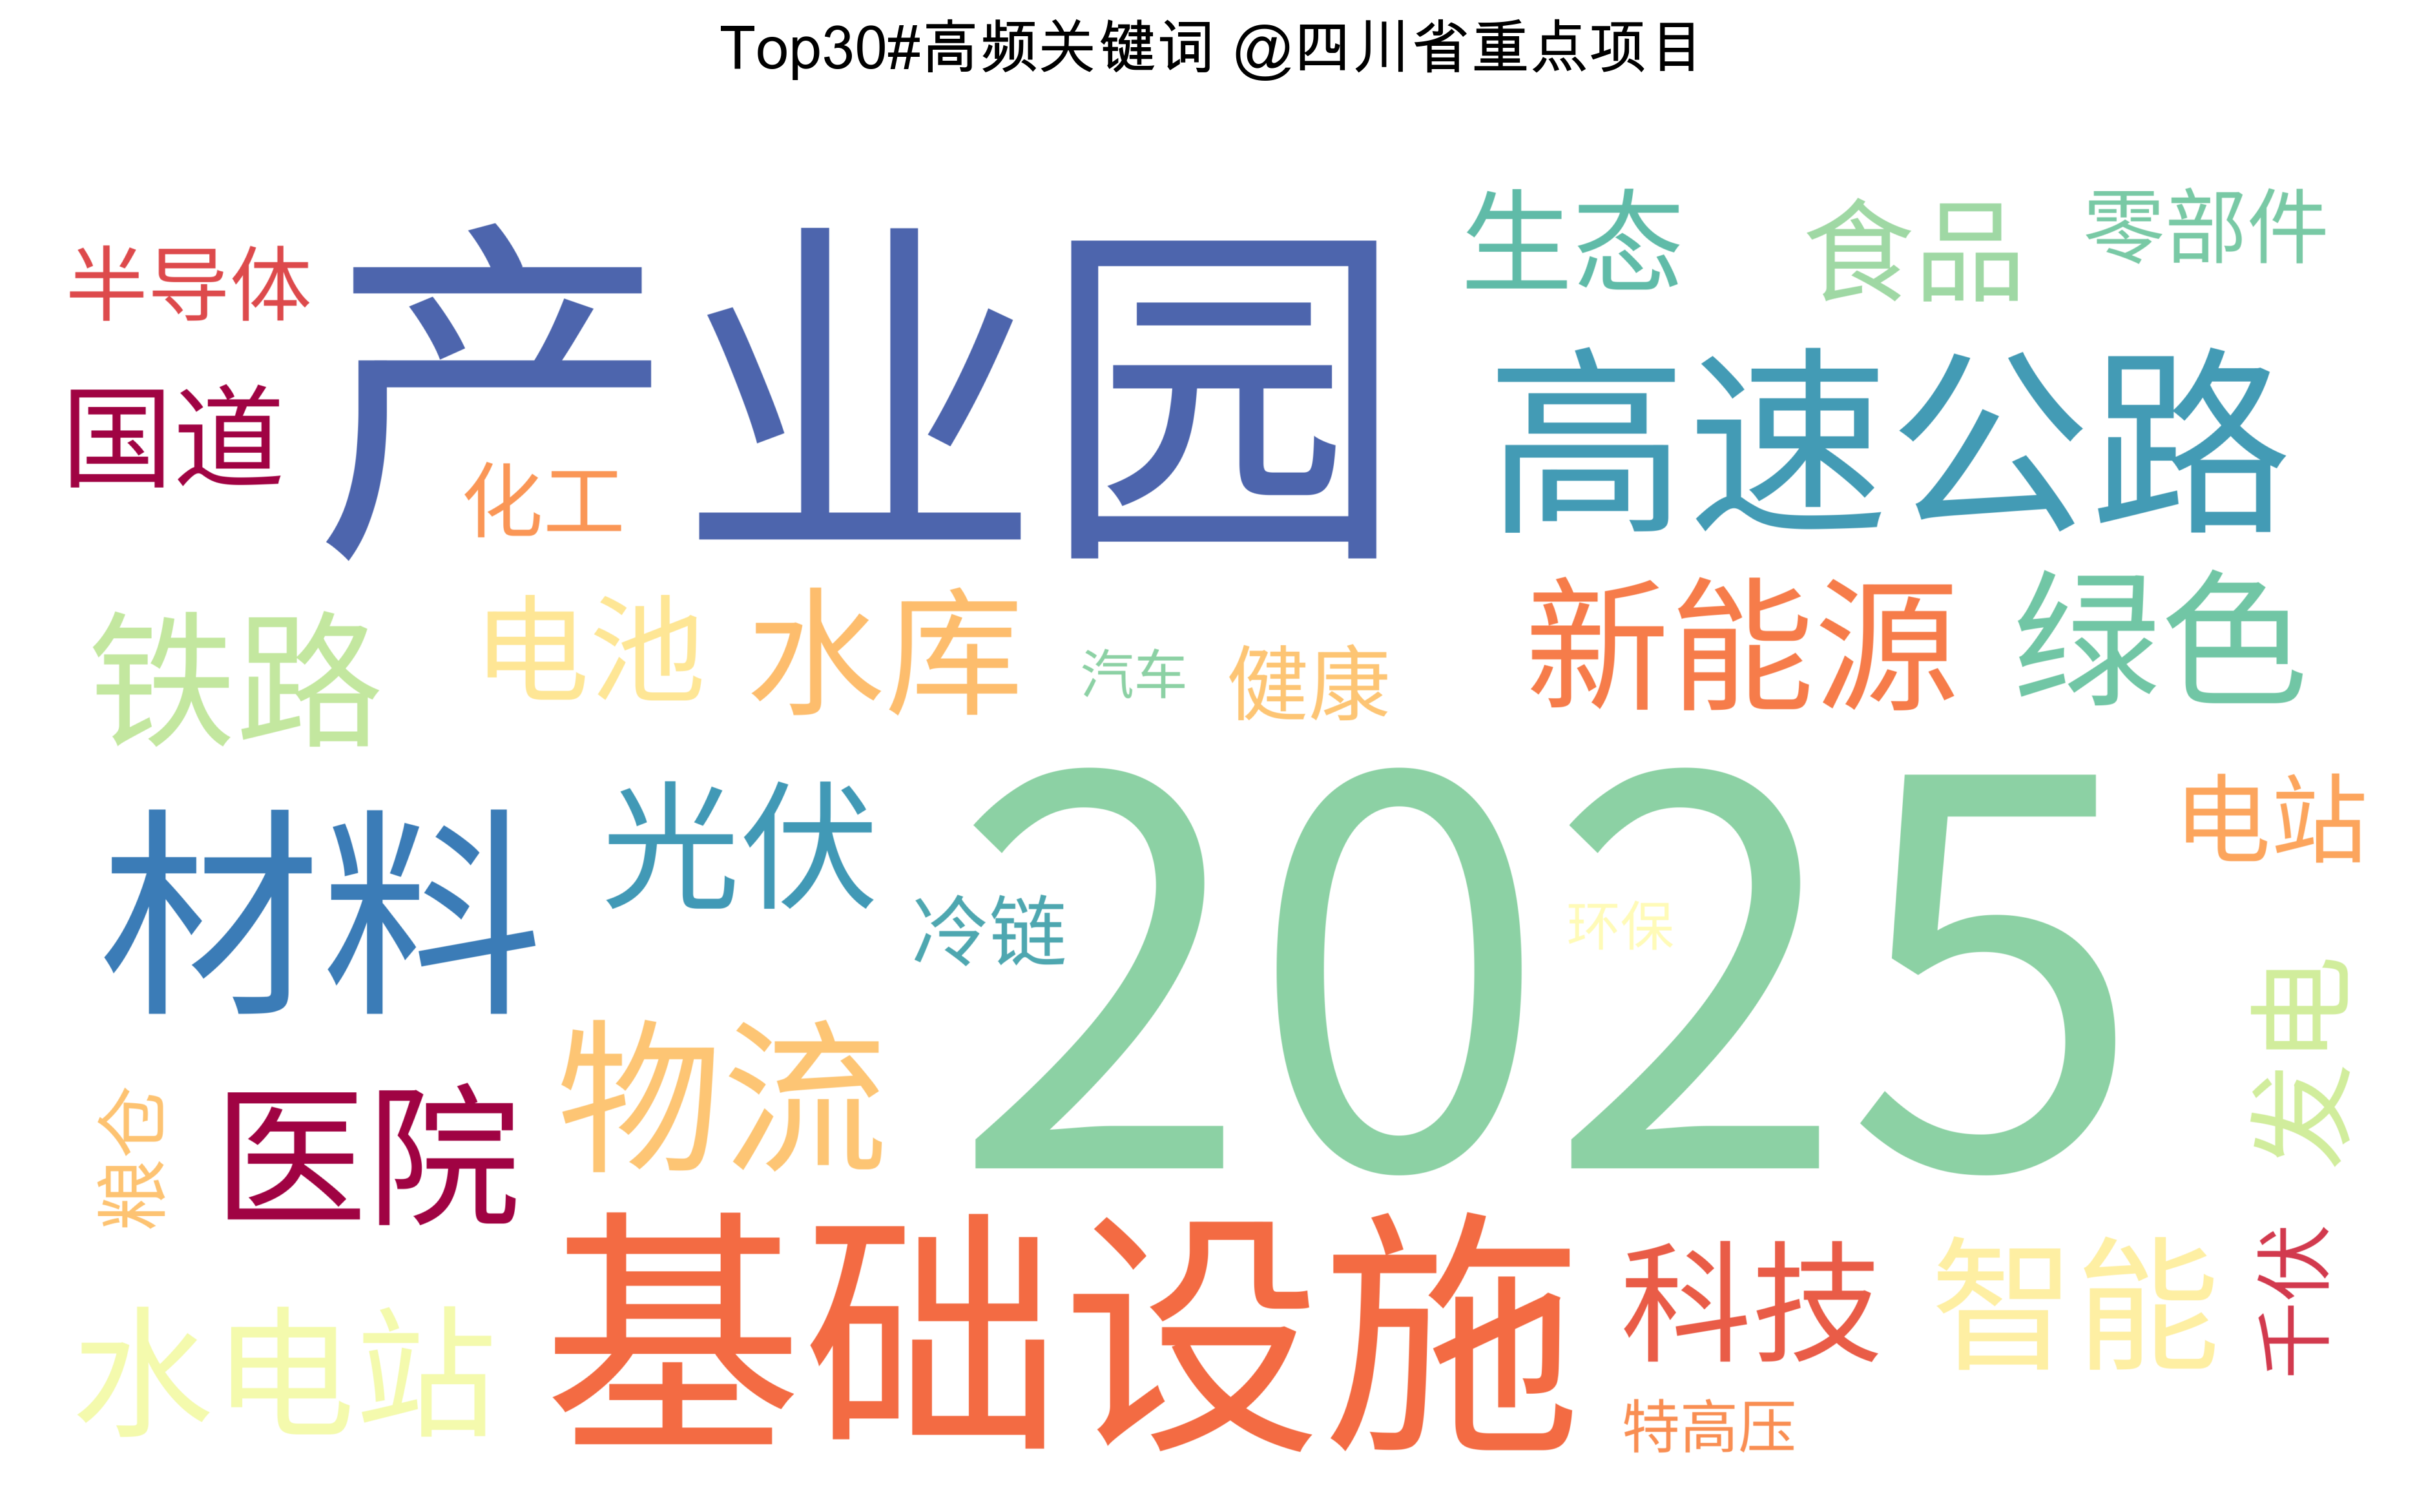

In [11]:
import jieba
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS']
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False  

def load_stop_words():
    """
    加载停用词列表
    
    返回:
    list - 停用词列表
    """
    with open("./stopwords/keyword_stopwords.txt", "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines()]

def extract_keywords(text, stop_words):
    words = jieba.lcut(text)  # 中文分词
    return [word for word in words if word not in stop_words and len(word) > 1]

def generate_word_freq_from_df(df, stop_words):
    """
    从DataFrame中提取关键词并生成词频字典
    
    参数:
    df: pandas.DataFrame - 包含项目名称的数据框
    stopwords: list - 停用词列表
    
    返回:
    dict - 词频字典
    """
    keywords = []
    for name in df["项目名称"]:
        keywords.extend(extract_keywords(str(name), stop_words))
    return pd.Series(keywords).value_counts().head(30).to_dict()

def generate_word_freq_from_df(df, stop_words, high_freq_word=None):
    """
    从DataFrame中提取关键词并生成词频字典
    
    参数:
    df: pandas.DataFrame - 包含项目名称的数据框
    stop_words: list - 停用词列表
    high_freq_word: str - 可选的高频词，如果提供将被插入到结果中
    
    返回:
    dict - 词频字典
    """
    keywords = []
    for name in df["项目名称"]:
        keywords.extend(extract_keywords(str(name), stop_words))
    
    word_freq = pd.Series(keywords).value_counts().head(30).to_dict()
    
    # 如果提供了高频词，将其插入到词频字典中
    if high_freq_word:
        # 将该词的频率设置为当前最高频率+1，确保它成为最高频词
        max_freq = max(word_freq.values()) if word_freq else 0
        word_freq[high_freq_word] = max_freq + 200
        
        # 重新排序，确保高频词在前面，然后取前30个
        word_freq = dict(word_freq.items())
    
    return word_freq

def generate_wordcloud(word_freq, title, figsize=(16, 9)):
    """
    生成词云图
    
    参数:
    word_freq: dict - 词频字典
    year: int - 年份
    font_path: str - 字体路径
    figsize: tuple - 图片大小
    """
    
    plt.figure(figsize=figsize)
    wc = WordCloud(
        width=1600,           
        height=900,           
        font_path="./fonts/NotoSansSC-Regular.ttf",
        font_step=10,
        min_font_size=30,
        max_font_size=360,
        background_color="white",
        # max_words=10,
        colormap = 'Spectral',
        # colormap = 'BuPu_r',
        # colormap = 'copper',
        # colormap = 'YlOrRd',
        # colormap = 'Set3',
        prefer_horizontal=0.85,
        margin=50,
        scale=3
    )

    wc.generate_from_frequencies(word_freq)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(
        title,
        fontsize=22,      
        fontweight='bold',
        pad=180,
        y=0.7,
    )
    
    plt.show()

if DEBUG and False:
    # 加载数据
    df_2024 = pd.read_csv("./outputs/2024年四川省重点项目名单_解析结果.csv")
    df_2025 = pd.read_csv("./outputs/2025年四川省重点项目名单_解析结果.csv")

    # 提取2024和2025年关键词
    keywords_2024 = []
    keywords_2025 = []

    for name in df_2024["项目名称"]:
        keywords_2024.extend(extract_keywords(str(name)))
    for name in df_2025["项目名称"]:
        keywords_2025.extend(extract_keywords(str(name)))

    print("🐳2024年关键词：\n", pd.Series(keywords_2024).value_counts().head(10))
    print("🐳2025年关键词：\n", pd.Series(keywords_2025).value_counts().head(10))

if '绘制词云' and True:
    # 加载数据
    df_2024 = pd.read_csv("./outputs/2024年四川省重点项目名单_解析结果.csv")
    df_2025 = pd.read_csv("./outputs/2025年四川省重点项目名单_解析结果.csv")
    
    stop_words = load_stop_words()
    # 生成词频数据
    word_freq_2024 = generate_word_freq_from_df(df_2024, stop_words, high_freq_word="2024")
    word_freq_2025 = generate_word_freq_from_df(df_2025, stop_words, high_freq_word="2025")
    
    # 生成词云
    generate_wordcloud(word_freq_2024, title="Top30#高频关键词 @四川省重点项目")
    generate_wordcloud(word_freq_2025, title="Top30#高频关键词 @四川省重点项目")

### 2.2 项目领域(一级)维度分析

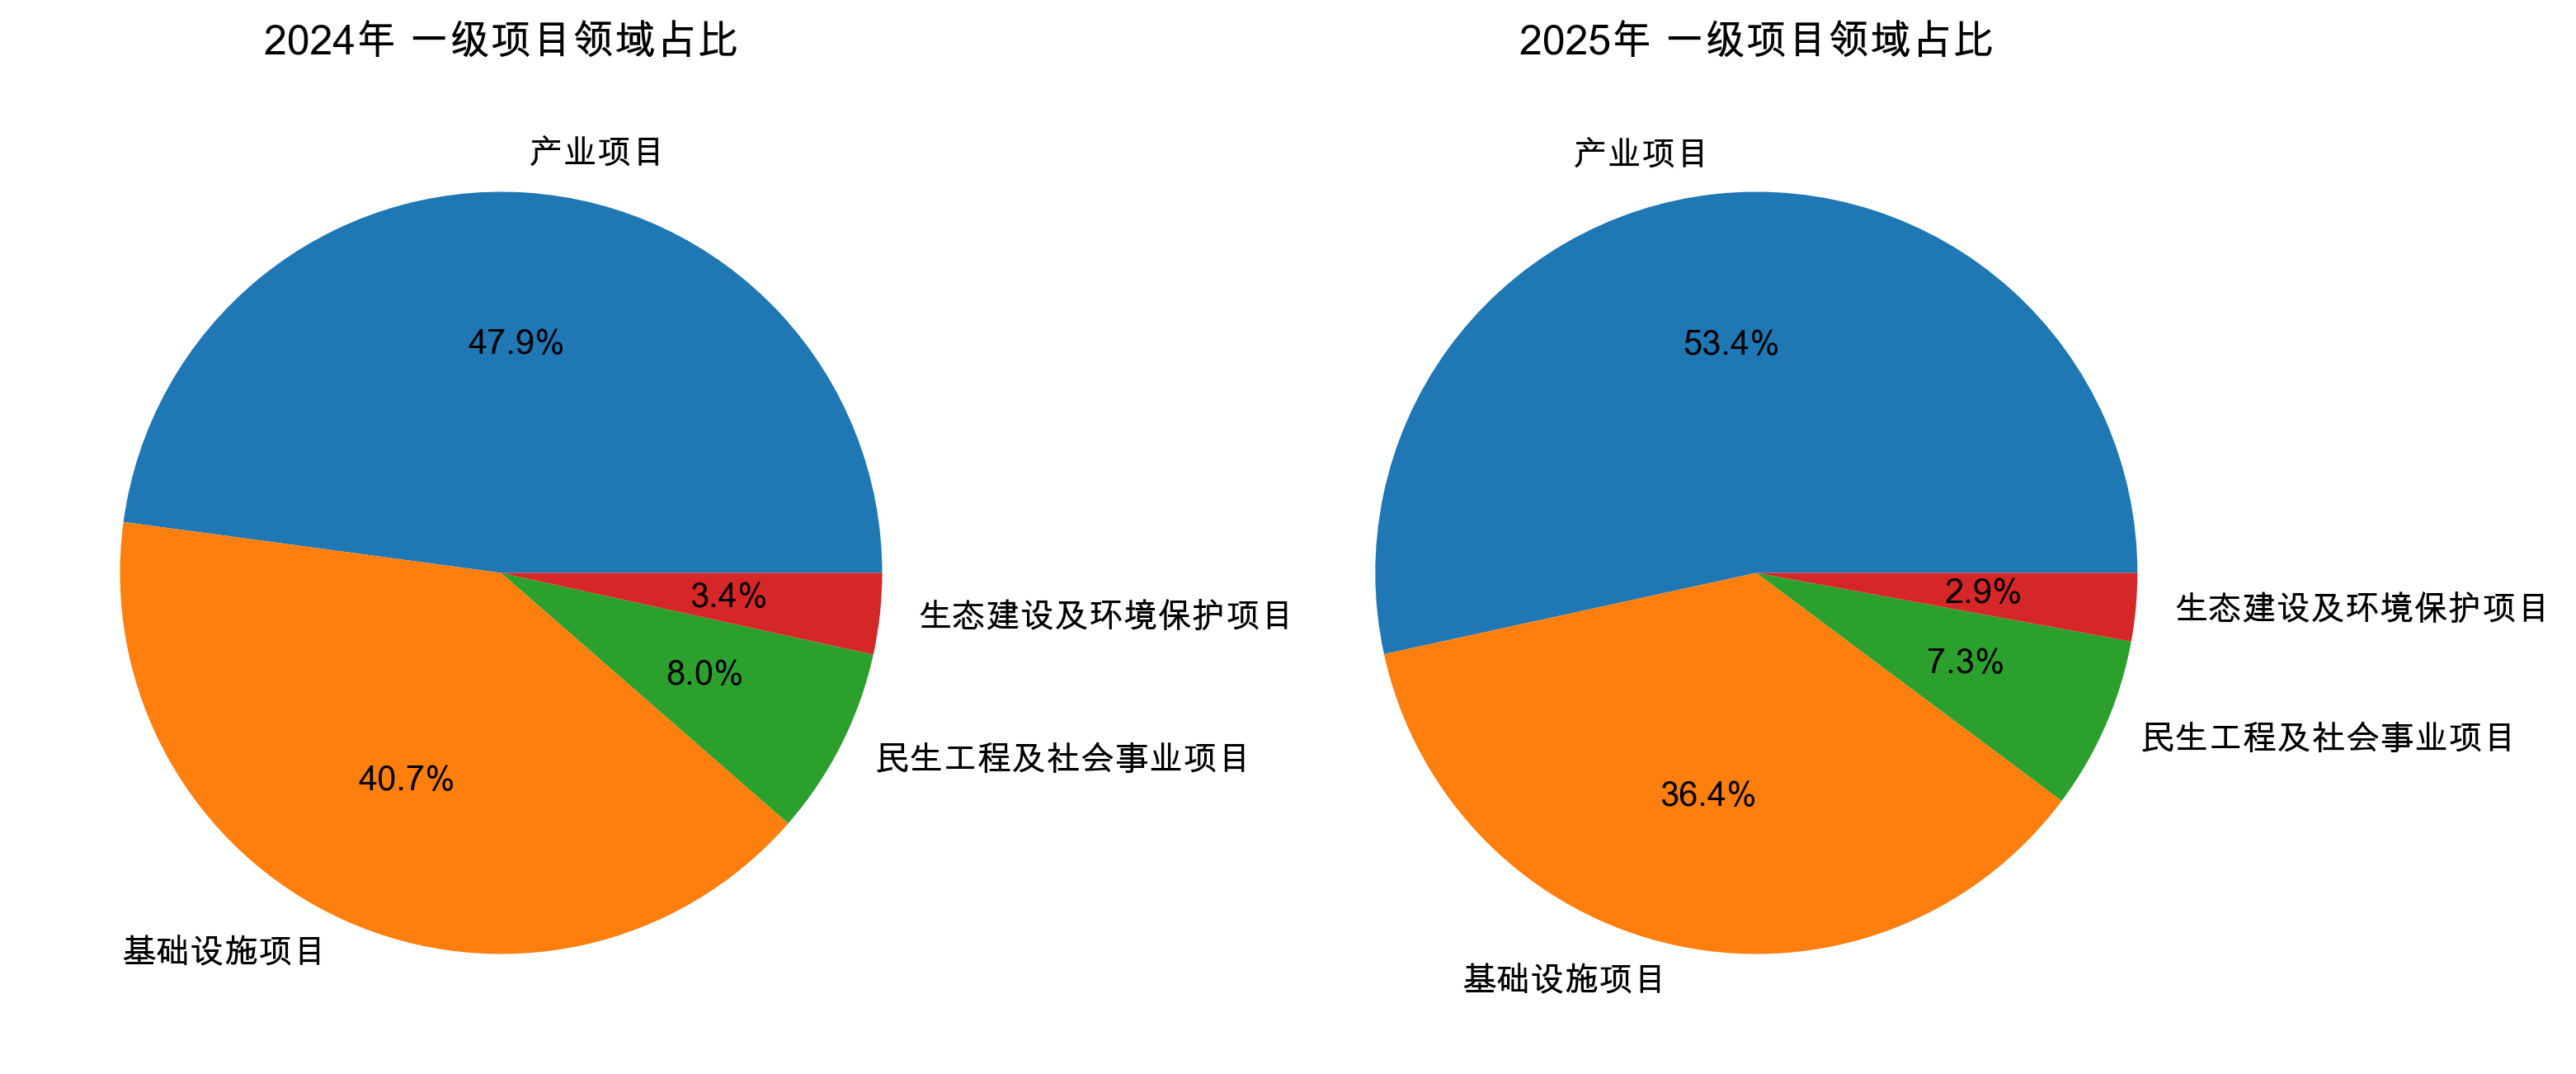

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['figure.dpi'] = 300

df_2024 = pd.read_csv("./outputs/2024年四川省重点项目名单_解析结果.csv")
df_2025 = pd.read_csv("./outputs/2025年四川省重点项目名单_解析结果.csv")

domain_distribution_2024 = df_2024['一级项目领域'].value_counts()
domain_distribution_2025 = df_2025['一级项目领域'].value_counts()

if "绘制饼图" and True:
  # 计算占比
  total_2024 = domain_distribution_2024.sum()
  total_2025 = domain_distribution_2025.sum()
  percentage_2024 = domain_distribution_2024 / total_2024 * 100
  percentage_2025 = domain_distribution_2025 / total_2025 * 100

  # 创建画布，包含两个子图
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  axes[0].pie(percentage_2024, labels=percentage_2024.index, autopct='%1.1f%%')
  axes[1].pie(percentage_2025, labels=percentage_2025.index, autopct='%1.1f%%')

  pad=40
  y=0.9
  axes[0].set_title('2024年 一级项目领域占比', pad=pad, y=y)
  axes[1].set_title('2025年 一级项目领域占比', pad=pad, y=y)

  plt.show()


### 2.3 项目领域(二级)维度分析

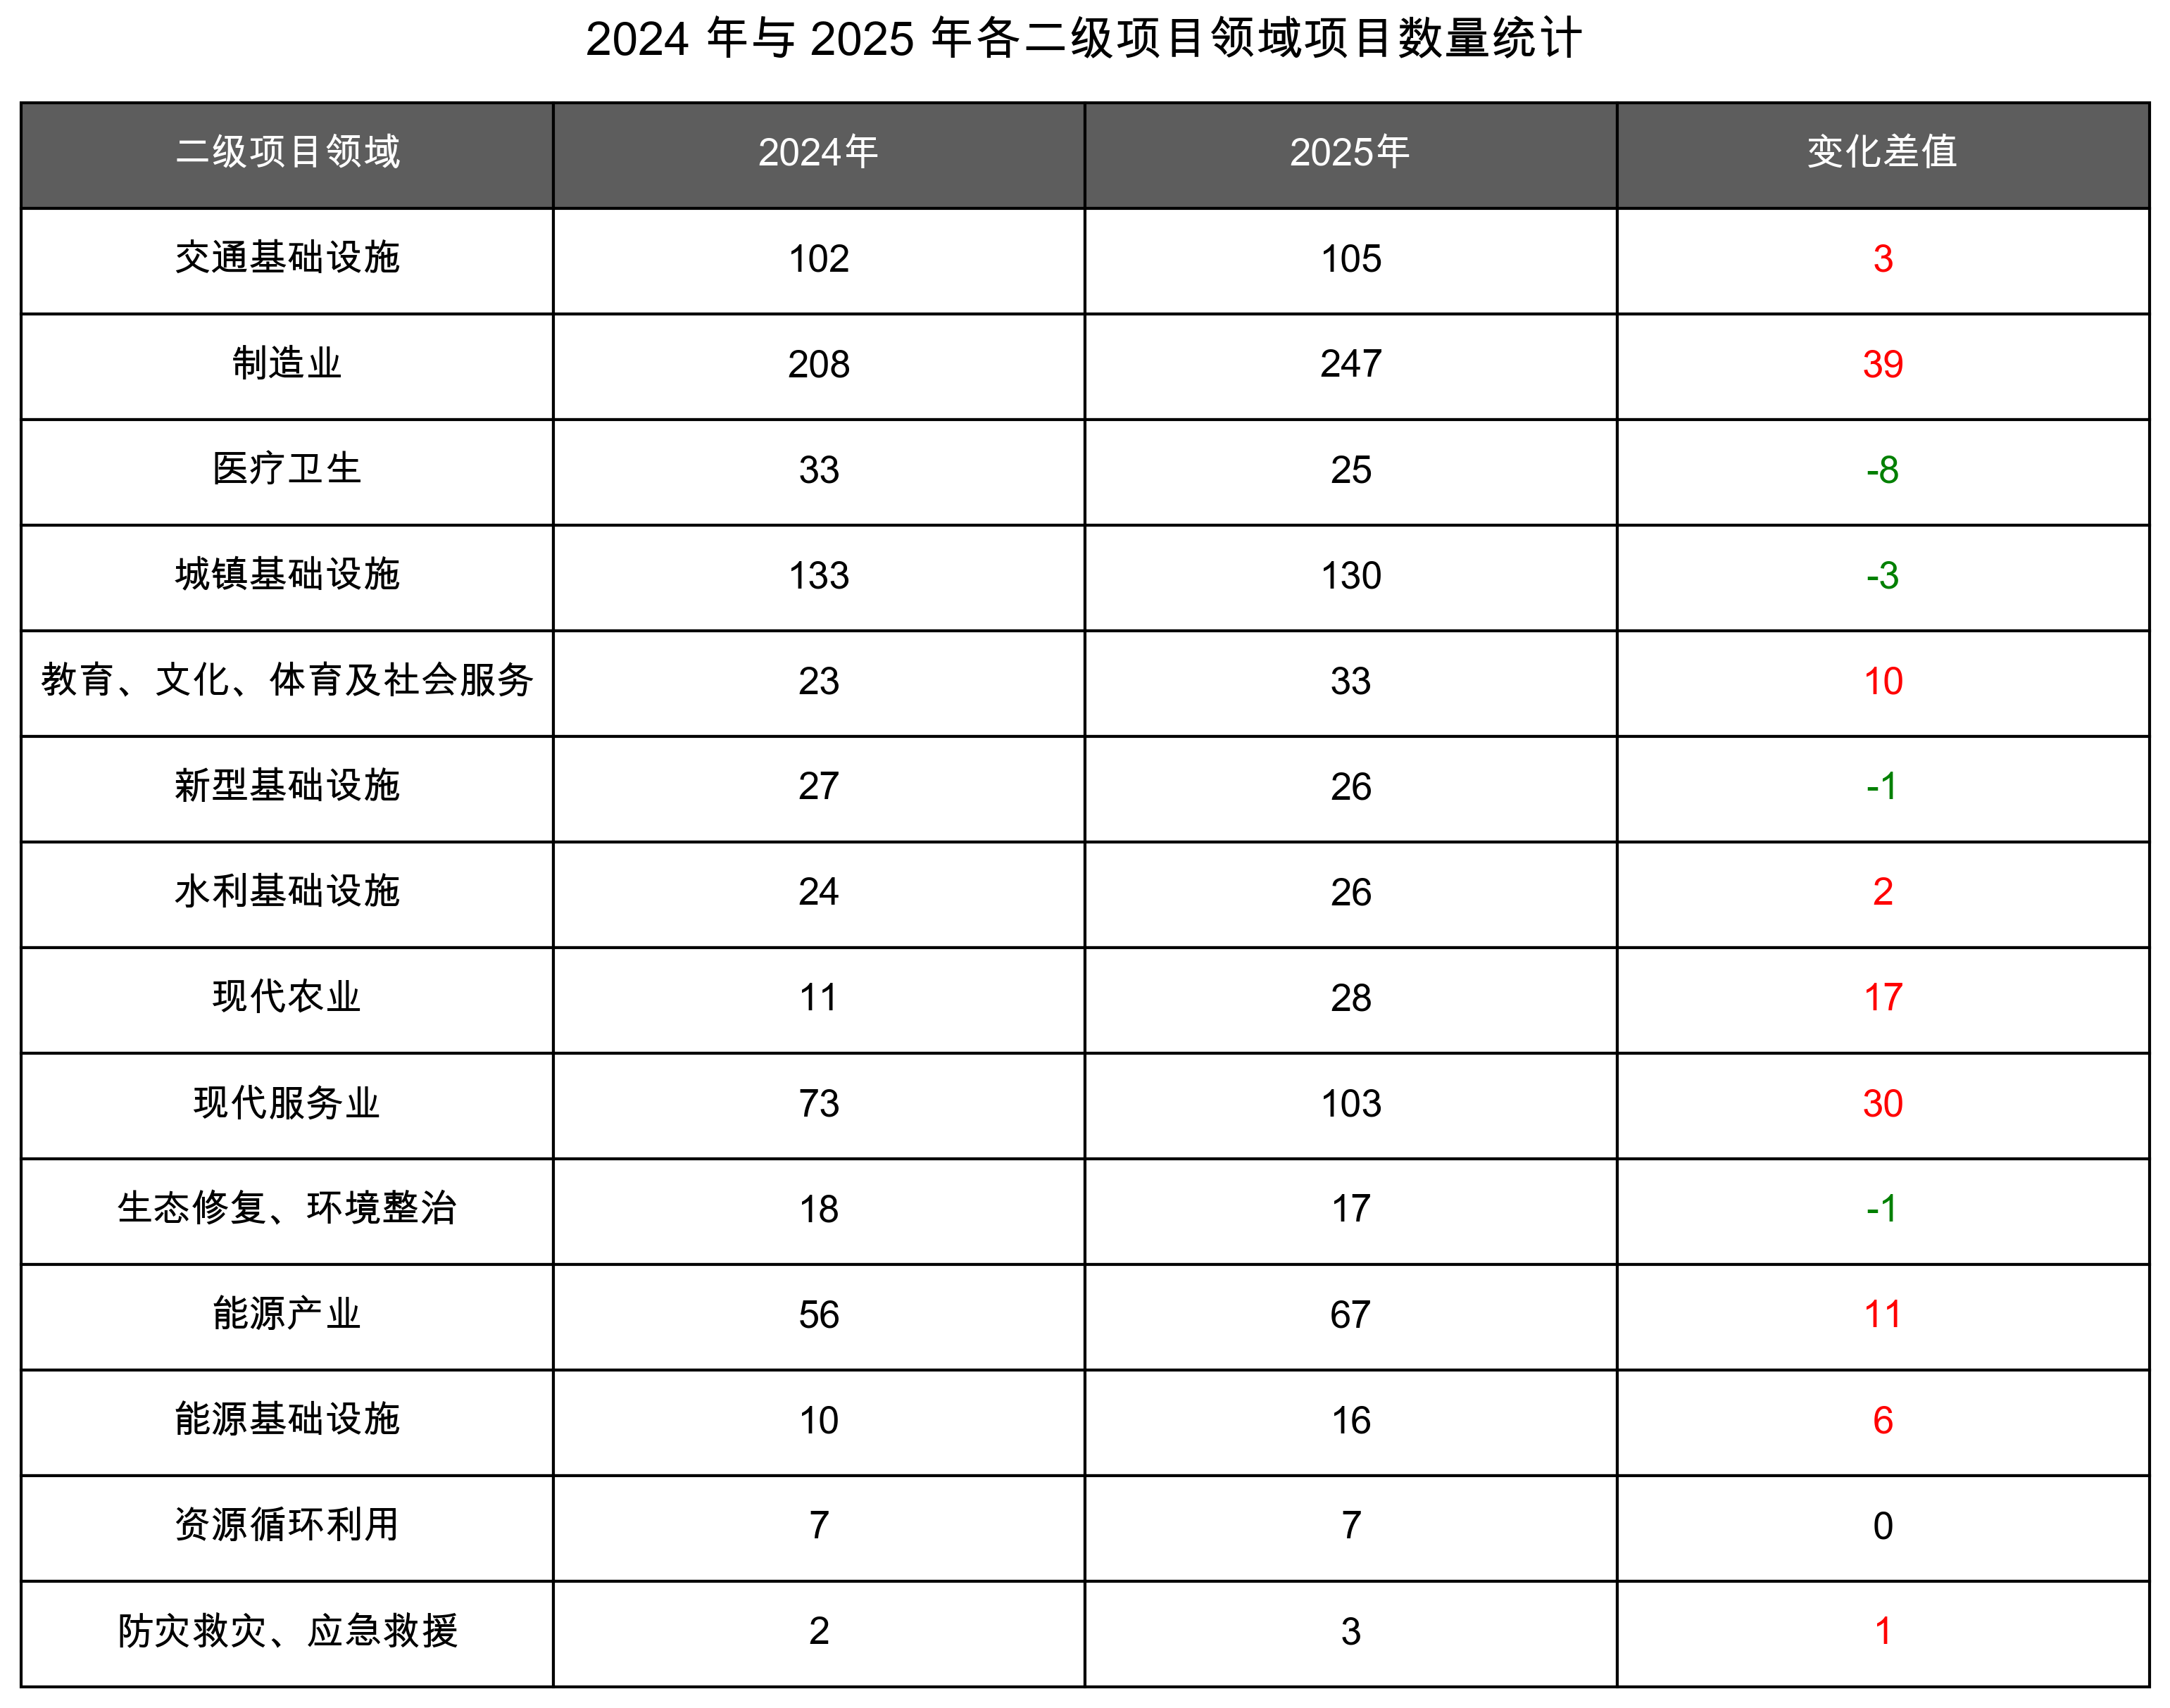

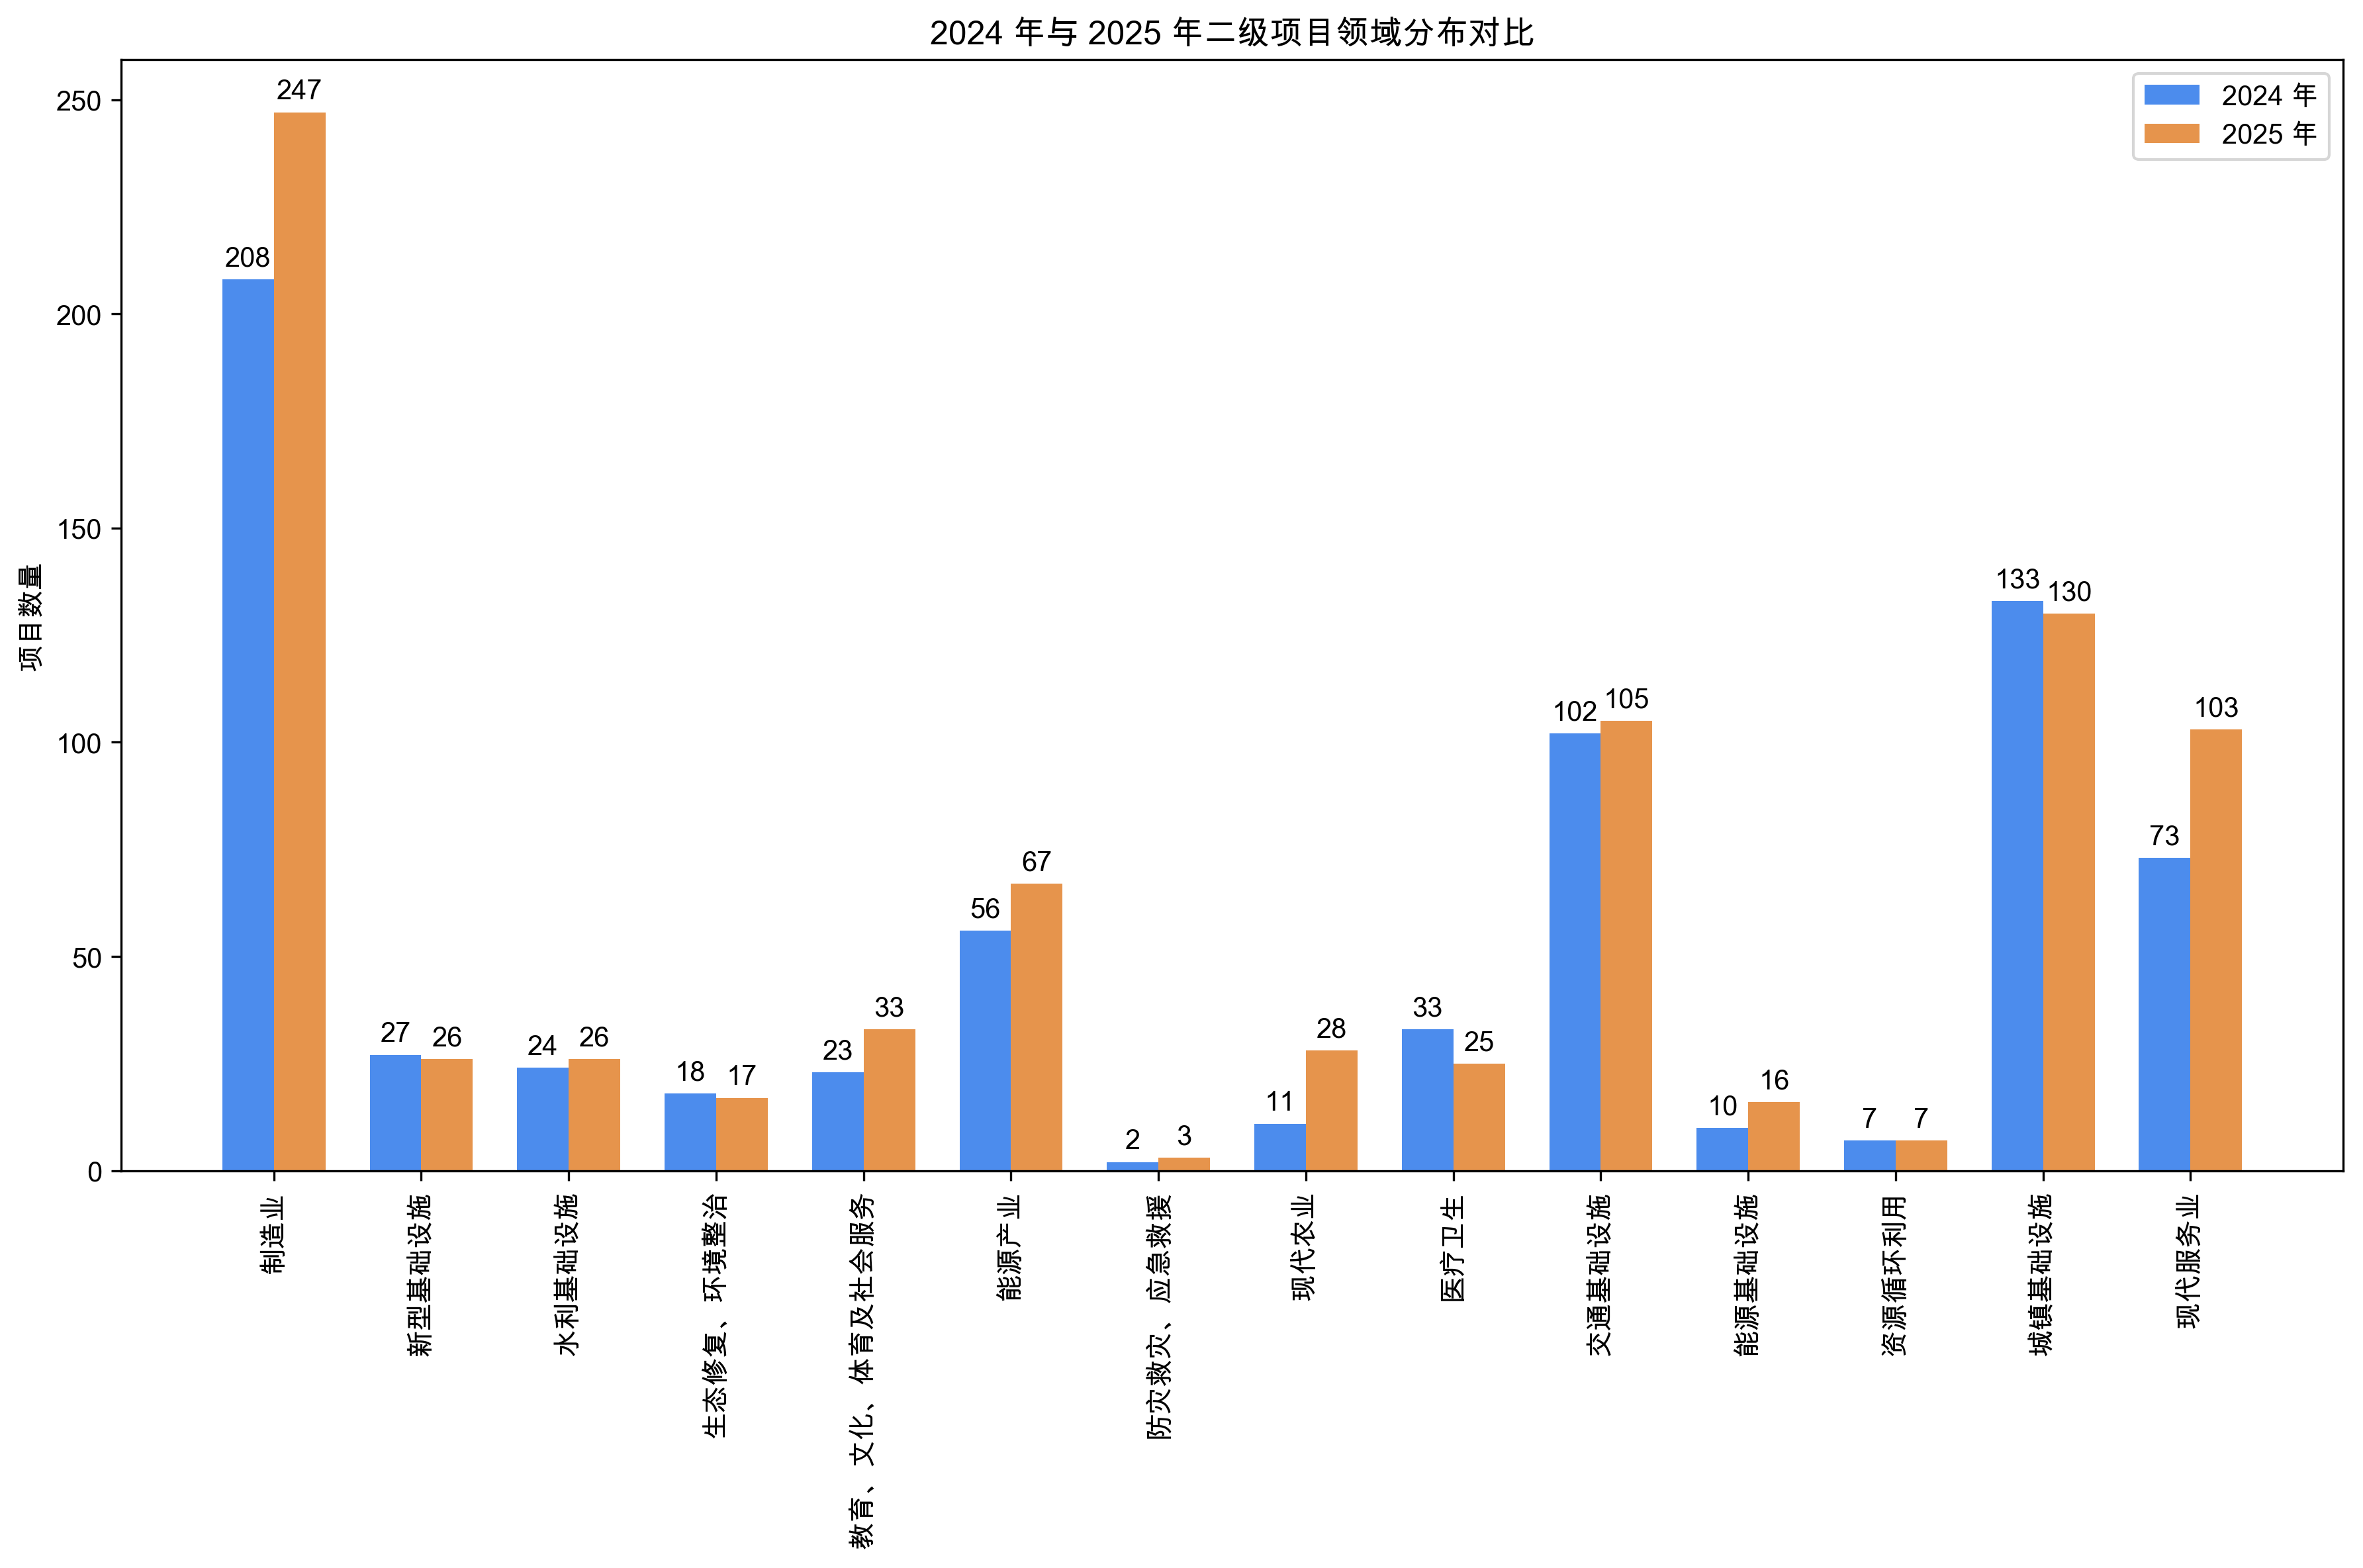

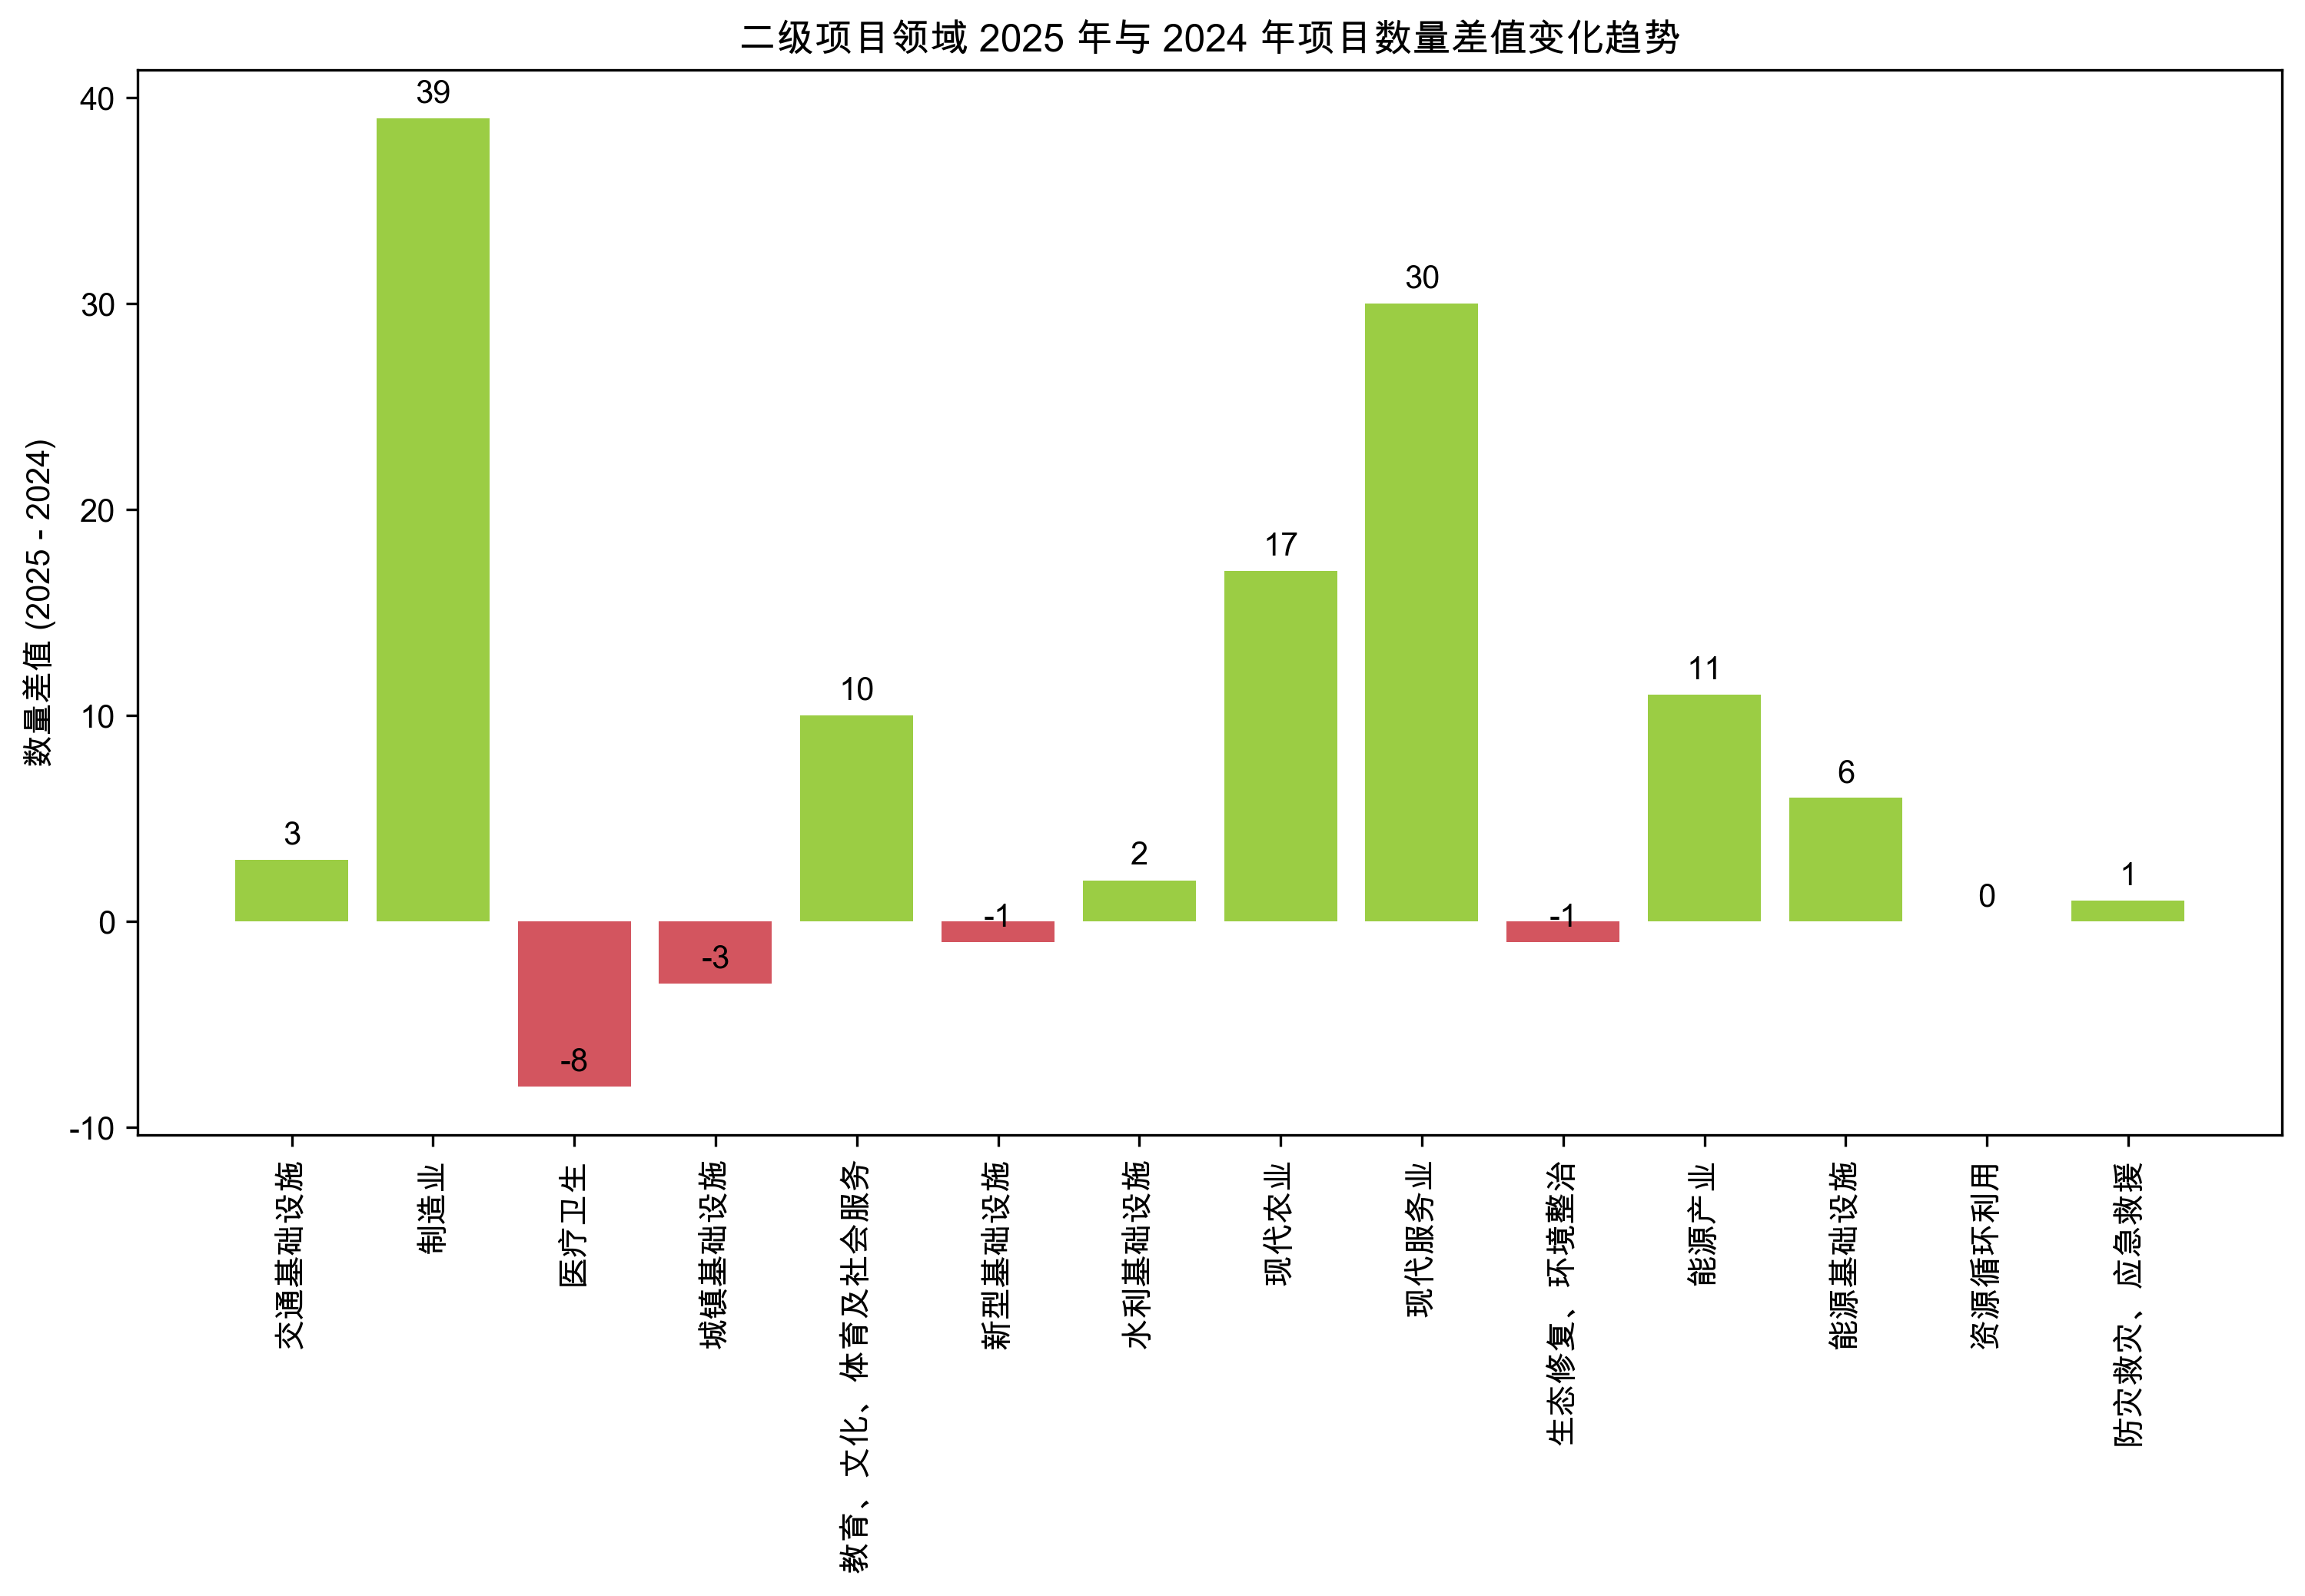

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['figure.dpi'] = 300

df_2024 = pd.read_csv("./outputs/2024年四川省重点项目名单_解析结果.csv")
df_2025 = pd.read_csv("./outputs/2025年四川省重点项目名单_解析结果.csv")

second_domain_distribution_2024 = df_2024['二级项目领域'].value_counts()
second_domain_distribution_2025 = df_2025['二级项目领域'].value_counts()

if '绘制表格' and True:
    # print('2024 年二级项目领域分布：')
    # print(second_domain_distribution_2024)
    # print('2025 年二级项目领域分布：')
    # print(second_domain_distribution_2025)

    # 将数据转换为 DataFrame
    df_2024 = pd.Series(second_domain_distribution_2024, name='2024年')
    df_2025 = pd.Series(second_domain_distribution_2025, name='2025年')

    # 合并两个年份的数据
    df_combined = pd.DataFrame({'2024年': df_2024, '2025年': df_2025})

    # 重置索引，将索引转换为列，并命名为"二级项目领域"
    df_combined = df_combined.reset_index()
    df_combined = df_combined.rename(columns={'index': '二级项目领域'})
    df_combined['变化差值'] = df_combined['2025年'] - df_combined['2024年']

    # 绘制表格
    fig, ax = plt.subplots(figsize=(6.5, 6)) 
    ax.axis('tight')
    ax.axis('off') 

    # 创建表格
    table = ax.table(cellText=df_combined.values,
                    colLabels=df_combined.columns,
                    cellLoc='center',
                    loc='center')

    # 设置表格样式
    table.auto_set_font_size(False)
    table.set_fontsize(13)
    table.scale(2, 3)  # 调整表格大小

   # 设置表头样式
    for i in range(len(df_combined.columns)):
        table[(0, i)].set_facecolor("#5d5d5d")
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # 设置"变化差值"列的颜色
    change_col_index = df_combined.columns.get_loc('变化差值')
    for i in range(1, len(df_combined)+1):  # 从1开始，跳过表头
        cell_value = df_combined.iloc[i-1]['变化差值']
        if cell_value > 0:
            table[(i, change_col_index)].set_text_props(color='r')
        elif cell_value < 0:
            table[(i, change_col_index)].set_text_props(color='g')

    # 添加标题
    ax.set_title('2024 年与 2025 年各二级项目领域项目数量统计', fontsize=16, pad=120)

    # 显示图表
    plt.show()

if '绘制对比柱状图' and True:

    # 找出两年都有的二级项目领域
    common_domains = set(second_domain_distribution_2024.index).intersection(set(second_domain_distribution_2025.index))

    # 构建新的 DataFrame 只包含共同的二级项目领域
    data = {
        '二级项目领域': list(common_domains),
        '2024年项目数量': [second_domain_distribution_2024[domain] for domain in common_domains],
        '2025年项目数量': [second_domain_distribution_2025[domain] for domain in common_domains]
    }
    df_common = pd.DataFrame(data)

    # 绘制柱状图
    x = range(len(df_common['二级项目领域']))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar([i - width/2 for i in x], df_common['2024年项目数量'], width, label='2024 年', color='#4C8CED')
    rects2 = ax.bar([i + width/2 for i in x], df_common['2025年项目数量'], width, label='2025 年', color='#E6944C')

    # 设置图表标题和坐标轴标签
    ax.set_ylabel('项目数量')
    ax.set_title('2024 年与 2025 年二级项目领域分布对比')
    ax.set_xticks(x)
    ax.set_xticklabels(df_common['二级项目领域'])
    ax.legend()

    # 添加数据标签
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

if '绘制差值柱状图' and True:
    # 计算差值
    diff = second_domain_distribution_2025 - second_domain_distribution_2024

    # 准备颜色列表
    colors = ['#9BCD44' if x > 0 else '#D3555F' for x in diff]

    # 绘制柱状图
    plt.figure(figsize=(12, 6))
    bars = plt.bar(diff.index, diff.values, color=colors)

    # 添加数据标签
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # 设置图表标题和坐标轴标签
    plt.title('二级项目领域 2025 年与 2024 年项目数量差值变化趋势')
    plt.ylabel('数量差值 (2025 - 2024)')
    plt.xticks(rotation=90)

    plt.show()


## 3. 综合分析结论